In [0]:
from IPython.display import clear_output
from google.colab import drive
drive.mount('/content/drive')
clear_output()

In [0]:
!pip install --upgrade tensorflow-gpu
!pip install wandb
clear_output()

In [0]:
import os
if(not os.path.exists("./Dataset/IMDB_Dataset.csv")):
  os.mkdir("./Dataset")
  if(os.path.exists("/content/drive/My Drive/SentimentAnalysisClassifier/Dataset/IMDB_Dataset.csv")):
    !cp -r "/content/drive/My Drive/SentimentAnalysisClassifier/Dataset/IMDB_Dataset.csv" ./Dataset/IMDB_Dataset.csv

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
#Change the path with "./Dataset/IMDB_Dataset.csv" for load the dataset from local
imdb_df = pd.read_csv("./Dataset/IMDB_Dataset.csv")
imdb_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [0]:
imdb_df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


In [0]:
#Check for nans
imdb_df.isna().sum()

review       0
sentiment    0
dtype: int64

In [0]:
#Encodes sentiment of the reviews
imdb_df["target"] = imdb_df.sentiment.astype("category").cat.codes
imdb_df.head()


,review,sentiment,target
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


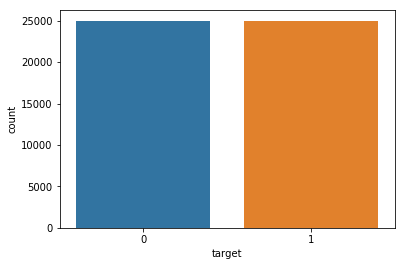

In [0]:
#Checks Dataset balance
sns.countplot(imdb_df["target"])
plt.show()

In [0]:
#Removes "<br />" from the text corpus, that have a high presence in the text corpus
imdb_df["review"] = imdb_df["review"].str.replace("<br />", "")
imdb_df.head()

,review,sentiment,target
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. The filming tec...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [0]:
#Tokenize the string into sequences of int, one unique int for every word found in the text corpus
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(imdb_df["review"])
imdb_df.insert(1, "tokens", tokenizer.texts_to_sequences(imdb_df["review"]))
imdb_df.head()

,review,tokens,sentiment,target
0,One of the other reviewers has mentioned that ...,"[26, 4, 1, 78, 2099, 44, 1071, 11, 99, 146, 38...",positive,1
1,A wonderful little production. The filming tec...,"[3, 392, 119, 351, 1, 1384, 2976, 6, 51, 17947...",positive,1
2,I thought this was a wonderful way to spend ti...,"[9, 189, 10, 12, 3, 392, 94, 5, 1153, 54, 19, ...",positive,1
3,Basically there's a family where a little boy ...,"[689, 221, 3, 235, 116, 3, 119, 419, 3651, 125...",negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...","[71931, 33185, 111, 7, 1, 54, 4, 290, 6, 3, 21...",positive,1


med: 173.0
80.0%: 319.0


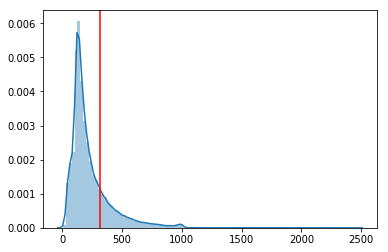

In [0]:
#Search for viable max lenght for seqeuences, avoiding space wasting by large number of zeros in every sequence
tokens_lenght = [len(seq) for seq in imdb_df["tokens"].values]
print("med: " + str(np.median(tokens_lenght)))

data_covered = 0.80
quantile = np.quantile(tokens_lenght, data_covered)
print(str(data_covered * 100) + "%: " + str(quantile))

sns.distplot(tokens_lenght, 100)
plt.axvline(quantile, color="red")
plt.show()

In [0]:
#Truncates only 5% of the data, and pad 95%
max_len = int(quantile)
imdb_df["tokens"] = tf.keras.preprocessing.sequence.pad_sequences(imdb_df["tokens"], max_len, padding="post", truncating="post").tolist()
imdb_df.head()

,review,tokens,sentiment,target
0,One of the other reviewers has mentioned that ...,"[26, 4, 1, 78, 2099, 44, 1071, 11, 99, 146, 38...",positive,1
1,A wonderful little production. The filming tec...,"[3, 392, 119, 351, 1, 1384, 2976, 6, 51, 17947...",positive,1
2,I thought this was a wonderful way to spend ti...,"[9, 189, 10, 12, 3, 392, 94, 5, 1153, 54, 19, ...",positive,1
3,Basically there's a family where a little boy ...,"[689, 221, 3, 235, 116, 3, 119, 419, 3651, 125...",negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...","[71931, 33185, 111, 7, 1, 54, 4, 290, 6, 3, 21...",positive,1


In [0]:
#splits data into Dataset ready for model training, evaluation and testing
imdb_ds = tf.data.Dataset.from_tensor_slices((imdb_df["tokens"], imdb_df["target"])).shuffle(2048)
imdb_test = imdb_ds.take(2500).batch(2500)
imdb_train = imdb_ds.skip(2500)
imdb_eval = imdb_train.take(2500).batch(2500)
imdb_train = imdb_train.skip(2500)

In [0]:
class DenseBlock(tf.keras.layers.Layer):
  "Dense + Dropout + BatchNorm"

  def __init__(self, units, dropout=0.1, l2=0.1):
    super(DenseBlock, self).__init__()

    self.bn = tf.keras.layers.BatchNormalization()
    self.drop = tf.keras.layers.Dropout(dropout)
    self.dense = tf.keras.layers.Dense(units, 
                                       "relu",
                                       kernel_regularizer=tf.keras.regularizers.L1L2(l2=l2),
                                       kernel_constraint=tf.keras.constraints.UnitNorm())
    
  def call(self, inputs):
    X = self.bn(inputs)
    X = self.drop(X)
    X = self.dense(X)
    return X

#Define our Model
class RNNClassifier(tf.keras.Model):
  """RNN Classifier"""

  def __init__(self, vocabulary_size, embedding_dim, dense_struct, lstm_units, lstm_count=1, dropout=0.1, l2=0.1):
    super(RNNClassifier, self).__init__()

    self.embedding = tf.keras.layers.Embedding(vocabulary_size, embedding_dim, mask_zero=True)

    self.lstm_list = list()
    for index in range(lstm_count):
      self.lstm_list.append(tf.keras.layers.LSTM(lstm_units, 
                                                 dropout=dropout, 
                                                 recurrent_dropout=dropout, 
                                                 kernel_regularizer=tf.keras.regularizers.L1L2(l2=l2), 
                                                 recurrent_regularizer=tf.keras.regularizers.L1L2(l2=l2), 
                                                 kernel_constraint=tf.keras.constraints.UnitNorm(), 
                                                 recurrent_constraint=tf.keras.constraints.UnitNorm(), 
                                                 return_sequences=True, 
                                                 return_state=True))

    self.dense_list = list()
    for layer in dense_struct:
      self.dense_list.append(DenseBlock(layer, dropout, l2))

    self.dense_out = tf.keras.layers.Dense(1, 
                                           "sigmoid",
                                           kernel_regularizer=tf.keras.regularizers.L1L2(l2=l2),
                                           kernel_constraint=tf.keras.constraints.UnitNorm())

  def call(self, inputs):
    X = self.embedding(inputs)

    output, state = None, None
    first_lstm = True
    for lstm in self.lstm_list:
      if(first_lstm):
        X, output, state = lstm(X)
        first_lstm = False
      else:
        X, o, s = lstm(X)
        output = tf.concat([output, o], axis=1)
        state = tf.concat([state, s], axis=1)

    #Y = tf.concat([output, state], axis=1)
    Y = output

    for layer in self.dense_list:
      Y = layer(Y)

    Y = self.dense_out(Y)
    return Y

In [0]:
#Parameters
vocabulary_size = len(tokenizer.word_index) + 1

#Hyperparameters
epochs = 50
lr = 0.005
embedding_dim = 8
batch_size = 2048
dropout = 0.0
l2 = 0.0001
lstm_units = 64
lstm_count = 1
dense_struct = [2]

In [0]:
#Model instantiation and compile
model = RNNClassifier(vocabulary_size, embedding_dim, dense_struct, lstm_units, lstm_count, dropout, l2)
model.compile(tf.keras.optimizers.Adam(lr), tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()])

In [0]:
#Fitting
model.fit(imdb_train.batch(batch_size), epochs=epochs, validation_data=imdb_eval)

Epoch 1/50
22/22 [==============================] - 29s 1s/step - loss: 0.6041 - binary_accuracy: 0.6932 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.0000e+00
Epoch 2/50
22/22 [==============================] - 22s 1000ms/step - loss: 0.3043 - binary_accuracy: 0.8984 - val_loss: 0.5533 - val_binary_accuracy: 0.8532
Epoch 3/50
22/22 [==============================] - 22s 993ms/step - loss: 0.1976 - binary_accuracy: 0.9477 - val_loss: 0.5238 - val_binary_accuracy: 0.9060
Epoch 4/50
22/22 [==============================] - 22s 996ms/step - loss: 0.1544 - binary_accuracy: 0.9652 - val_loss: 0.4607 - val_binary_accuracy: 0.8692
Epoch 5/50
22/22 [==============================] - 22s 1000ms/step - loss: 0.1199 - binary_accuracy: 0.9790 - val_loss: 0.4159 - val_binary_accuracy: 0.9164
Epoch 6/50
22/22 [==============================] - 22s 996ms/step - loss: 0.1050 - binary_accuracy: 0.9842 - val_loss: 0.4605 - val_binary_accuracy: 0.9068
Epoch 7/50
22/22 [==============================] -

In [0]:
#Evaluate using test set
model.evaluate(imdb_test)

1/1 [==============================] - 1s 533ms/step - loss: 0.0759 - binary_accuracy: 0.9936


[0.0758996456861496, 0.9936]

In [0]:
#Save model weights to a new folder
dir_list = os.listdir("/content/drive/My Drive/SentimentAnalysisClassifier/Checkpoints/")
dir_list = list(map(int, dir_list))
next_dir = np.max(dir_list)
next_dir = "/content/drive/My Drive/SentimentAnalysisClassifier/Checkpoints/" + str(next_dir + 1)
os.mkdir(next_dir)

model.save_weights(next_dir + "/checkpoint")

In [0]:
#Preprocess raw text
def preprocess_text(str_list):
  seq_list = tokenizer.texts_to_sequences(str_list)
  seq_list = tf.keras.preprocessing.sequence.pad_sequences(seq_list, max_len, padding="post", truncating="post")
  return seq_list
  
#Make inference on custom test
test_review = input()
test_tokens = np.array(preprocess_text([test_review]))
result = model(test_tokens)
print(float(result))
if(result >= 0.5):
  print("positive")
else:
  print("negative")

this is an awesome movie
0.9916233420372009
positive
